In [46]:
import pandas as pd
import numpy as np
import os
import json
import statistics
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
from dateutil.tz import tzutc
import math

In [2]:
d = "./result_long"

dirs_to_analyze = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and "\\experiment" in os.path.join(d, o)]


In [89]:
rowsList = []
numjobs = []
batches = []

for curdir in dirs_to_analyze:
    row = {}    
    try:
        time_summary = json.load(open(curdir + "/summary.json"))
        service_times = []
        process_times = []
        wait_times = []
        
        start_time = parser.parse(time_summary["start"])
        end_time = parser.parse(time_summary["shutdown"])

        time_offset = datetime.timedelta(minutes=30)
        batch_start_time = start_time + time_offset

        batch_start_seconds = (batch_start_time-datetime.datetime(1970,1,1).replace(tzinfo=tzutc())).total_seconds()
        end_seconds = (end_time.replace(tzinfo=None)-datetime.datetime(1970,1,1)).total_seconds()

        num_batches = 4

        batch_delta = (end_seconds - batch_start_seconds) / float(num_batches)


        batch_num = 0
        batch_jobs = []

        for batch_start in np.arange(batch_start_seconds, end_seconds, batch_delta):
            batch_num = batch_num + 1
#             print("Batch ", batch_num)
#             print(batch_start, " - ", batch_start + batch_delta)
            new_batch_jobs = []

            i = -1
            for job in time_summary['jobs']:
                i = i + 1
                if (float(job['end']) >= batch_start) & (float(job['end']) < batch_start + batch_delta):
                    new_batch_jobs.append(i)

#             print("Num jobs", len(new_batch_jobs))
            numjobs.append(len(new_batch_jobs))
            batch_jobs.append(new_batch_jobs)
        
        batches.append(batch_jobs)
        
        row['Num generated'] = time_summary['jobCount']

        for job in time_summary['jobs']:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)

        row['Service Time mean'] = statistics.mean(service_times)
        row['Service Time std'] = statistics.stdev(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Process Time std'] = statistics.stdev(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Waiting Time std'] = statistics.stdev(wait_times)
    except Exception as e:
        print("Error parsing time summary for folder " + curdir)
        print(e)
        
    try:
        config = json.load(open(curdir + "/config.json"))
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])

    except Exception as e:
        print("Error parsing config for folder " + curdir)
        print(e)
        
    try:
        accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
        row['Num finished'] = accuracy["top1"].count()
        row['Top 1 mean'] = accuracy["top1"].mean()
        row['Top 1 std'] = accuracy["top1"].std()
        row['Top 5 mean'] = accuracy["top5"].mean()
        row['Top 5 std'] = accuracy["top5"].std()
        row['loss mean'] = accuracy["loss"].mean()
        row['loss std'] = accuracy["loss"].std()
        row['lossnum'] = accuracy["lossnum"].mean()
    except Exception as e:
        print("Error parsing accuracy for folder " + curdir)
        print(e)
        
    
    rowsList.append(row) 
    
analysis_old = pd.DataFrame(rowsList)
# analysis_old

In [90]:
mu = 0.90
sigma = 0.05
def z_score(x, mu, sig):
    return (x-mu)/sig

In [91]:
## Creating batches
rowsList = []
numjobs = []

new_df = pd.DataFrame(columns=analysis.columns)
i = -1
for curdir in dirs_to_analyze:
#     print(curdir)
    i = i + 1
    time_summary = json.load(open(curdir + "/summary.json"))
    config = json.load(open(curdir + "/config.json"))
    accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
    accuracy["Experiment"] = [int(x.split(".")[0]) for x in accuracy.index]

    experiment_batches = batches[i]
    batch_num = 0
    for curbat in experiment_batches:
        batch_num = batch_num + 1
        if len(curbat) == 0:
            continue
        row = {}
        
        service_times = []
        process_times = []
        wait_times = []
        batch_summary = time_summary['jobs'][min(curbat):max(curbat)+1]
        for job in batch_summary:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)
        row['Batch Number'] = batch_num
        row['Experiment Number'] = i
        row['Service Time mean'] = statistics.mean(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])
        
        
        row['Experiment Name'] = str(row['Batch Size']) + " - " + str(row['Max Epochs']) + " - " + str(row['Learning Rate'])
        
        batch_accuracy = accuracy[accuracy["Experiment"].isin(curbat)]
        row['Num finished'] = batch_accuracy["top1"].count()
        row['Top 1 mean'] = batch_accuracy["top1"].mean()
        row['Top 1 std'] = batch_accuracy["top1"].std()
        row['Top 5 mean'] = batch_accuracy["top5"].mean()
        row['Top 5 std'] = batch_accuracy["top5"].std()
        row['loss mean'] = batch_accuracy["loss"].mean()
        row['loss std'] = batch_accuracy["loss"].std()
        row['lossnum'] = batch_accuracy["lossnum"].mean()
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Final1'] = row['Service Time mean'] / math.e**row['Zscore1']
        row['Final5'] = row['Service Time mean'] / math.e**row['Zscore5']
        
        rowsList.append(row) 
    
analysis_batch = pd.DataFrame(rowsList)
analysis_batch

,Batch Number,Experiment Number,Service Time mean,Process Time mean,Waiting Time mean,Executor Memory,Batch Size,Max Epochs,Learning Rate,Nodes,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Zscore1,Zscore5,Final1,Final5
0,1,0,523.205719,523.205645,0.000074,1,128,10,0.005,1,...,0.008061,0.995400,0.000283,0.320982,0.010210,157.0,0.278000,1.908000,396.221888,77.631642
1,2,0,521.276814,521.276731,0.000083,1,128,10,0.005,1,...,0.002553,0.996533,0.000473,0.306239,0.004603,157.0,0.356000,1.930667,365.140068,75.611964
2,3,0,789.010816,529.829070,259.181745,1,128,10,0.005,1,...,0.005302,0.995680,0.000517,0.314583,0.016267,157.0,0.327600,1.913600,568.601743,116.417173
3,4,0,1449.641481,545.099980,904.541502,1,128,10,0.005,1,...,0.003976,0.996167,0.000712,0.305998,0.015216,157.0,0.388333,1.923333,983.127119,211.820289
4,1,1,1817.286394,919.909957,897.376438,1,128,20,0.005,1,...,0.002304,0.997920,0.000356,0.221667,0.008146,157.0,0.736400,1.958400,870.179739,256.389985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,4,25,12157.408238,1561.927681,10595.480557,1,64,20,0.020,1,...,0.000757,0.999867,0.000058,0.069822,0.001971,313.0,1.586666,1.997333,2487.485325,1649.719754
100,1,26,923.621292,484.908643,438.712648,1,64,5,0.020,1,...,0.002140,0.999500,0.000115,0.114563,0.005581,313.0,1.326857,1.990000,245.045719,126.254821
101,2,26,431.771805,431.771597,0.000208,1,64,5,0.020,1,...,0.002258,0.999650,0.000129,0.117241,0.006077,313.0,1.301000,1.993000,117.553939,58.844430
102,3,26,460.051439,460.051366,0.000073,1,64,5,0.020,1,...,NaN,0.999600,NaN,0.125618,NaN,313.0,1.248000,1.992000,132.070771,62.761287


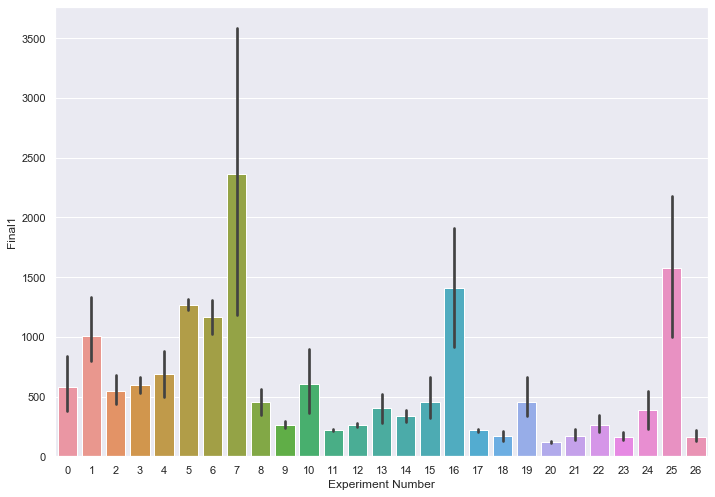

In [92]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x="Experiment Number", y="Final1", data=analysis_batch)

(0.8, 1.0)

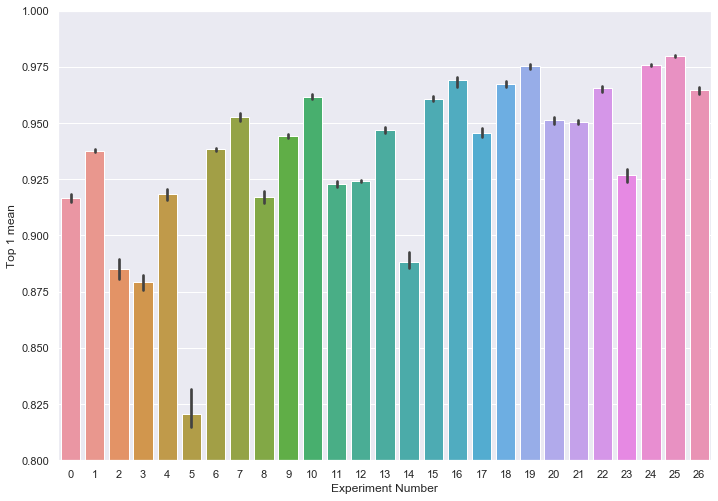

In [93]:
bp = sns.barplot(x="Experiment Number", y="Top 1 mean", data=analysis_batch)
axes = bp.axes
axes.set_ylim(0.8,1.0)

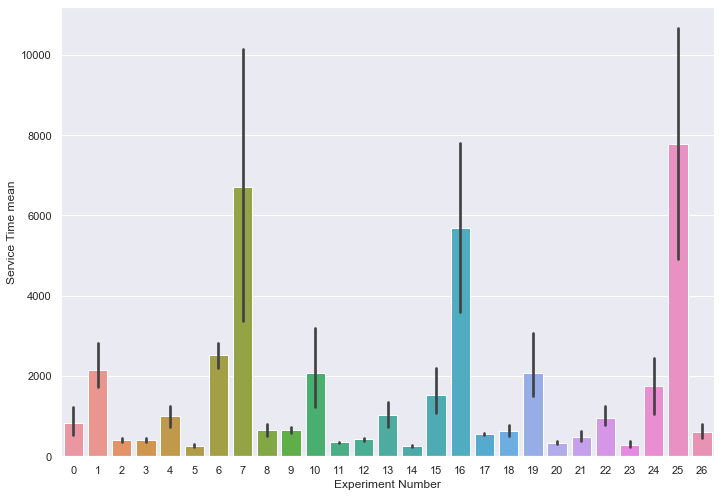

In [94]:
bp = sns.barplot(x="Experiment Number", y="Service Time mean", data=analysis_batch)


In [42]:
# Fits the model with the interaction term
print(analysis.columns)
analysis2 = analysis_batch[["Top 1 mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Top 1 mean": "Acc", "Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('Acc ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Index(['Num generated', 'Service Time mean', 'Service Time std',
       'Process Time mean', 'Process Time std', 'Waiting Time mean',
       'Waiting Time std', 'Executor Memory', 'Batch Size', 'Max Epochs',
       'Learning Rate', 'Nodes', 'Lambda', 'Num finished', 'Top 1 mean',
       'Top 1 std', 'Top 5 mean', 'Top 5 std', 'loss mean', 'loss std',
       'lossnum', 'Service/Zscore', 'Acc/Service', 'LISAS', 'RCS'],
      dtype='object')
Overall model F( 26, 53) =  632.570, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Acc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     632.6
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           2.67e-57
Time:                        15:12:18   Log-Likelihood:                 388.78
No. Observations:                  80   AIC:                            -723.6
Df Residuals:                      53   BIC:                            -659.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.9161      0.001    688.488      0.000       0.913       0.919
C(BS)[T.128]                              -0.0296      0.002    -15.716      0.000      -0.033      -0.026
C(BS)[T.256]                              -0.0956      0.002    -45.458      0.000      -0.100      -0.091
C(ME)[T.10]                                0.0222      0.002     11.799      0.000       0.018       0.026
C(ME)[T.20]                                0.0365      0.002     19.391      0.000       0.033       0.040
C(LR)[T.0.01]                              0.0295      0.002     15.663      0.000       0.026       0.033
C(LR)[T.0.02]                              0.0493      0.002     26.193      0.000       0.046       0.053
C(BS)[T.128]:C(ME)[T.10]                   0.0082      0.003      3.086      0.003       0.003       0.014
C(BS)[T.256]:C(ME)[T.10]                   0.0385      0.003     13.624      0.000       0.033       0.044
C(BS)[T.128]:C(ME)[T.20]                   0.0148      0.003      5.553      0.000       0.009       0.020
C(BS)[T.256]:C(ME)[T.20]                   0.0613      0.003     21.700      0.000       0.056       0.067
C(BS)[T.128]:C(LR)[T.0.01]                 0.0067      0.003      2.503      0.015       0.001       0.012
C(BS)[T.256]:C(LR)[T.0.01]                 0.0378      0.003     13.406      0.000       0.032       0.044
C(BS)[T.128]:C(LR)[T.0.02]                 0.0156      0.003      5.853      0.000       0.010       0.021
C(BS)[T.256]:C(LR)[T.0.02]                 0.0573      0.003     20.285      0.000       0.052       0.063
C(ME)[T.10]:C(LR)[T.0.01]                 -0.0070      0.003     -2.639      0.011      -0.012      -0.002
C(ME)[T.20]:C(LR)[T.0.01]                 -0.0130      0.003     -4.880      0.000      -0.018      -0.008
C(ME)[T.10]:C(LR)[T.0.02]                 -0.0117      0.003     -4.384      0.000      -0.017      -0.006
C(ME)[T.20]:C(LR)[T.0.02]                 -0.0223      0.003     -8.374      0.000      -0.028      -0.017
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0018      0.004     -0.489      0.627      -0.009       0.006
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.01]    -0.0174      0.004     -4.481      0.000      -0.025      -0.010
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.01]     0.0006      0.004      0.155      0.877      -0.007       0.008
C(BS)[T.256]:C(ME)[T.20]:C(LR)[T.0.01]    -0.0257      0.004     -6.614      0.000      -0.033      -0.018
C(BS)[T.128]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0032      0.004     -0.843      0.403      -0.011       0.004
C(BS)[T.256]:C(ME)[T.10]:C(LR)[T.0.02]    -0.0256      0.004     -6.599      0.000      -0.033      -0.018
C(BS)[T.128]:C(ME)[T.20]:C(LR)[T.0.02]    -0.0052      0.004     -1.374      0.175     

,sum_sq,df,F,PR(>F)
C(BS),0.022765,2.0,2142.948134,2.007983e-51
C(ME),0.022794,2.0,2145.637415,1.943132e-51
C(LR),0.037595,2.0,3538.857109,3.848444e-57
C(BS):C(ME),0.003456,4.0,162.660106,4.416949e-29
C(BS):C(LR),0.002812,4.0,132.343523,6.530221e-27
C(ME):C(LR),0.002738,4.0,128.884802,1.232009e-26
C(BS):C(ME):C(LR),0.000626,8.0,14.732397,4.486093e-11
Residual,0.000282,53.0,NaN,NaN


In [22]:
# Process time results:
print("Max avg process time: ", analysis["Process Time mean"].max())
print("Min avg process time: ", analysis["Process Time mean"].min())
print("Mean avg process time: ", analysis["Process Time mean"].mean())

print("Min mu: ", "%.7f" % (1/analysis["Process Time mean"].max()))
print("Max mu: ", "%.7f" % (1/analysis["Process Time mean"].min()))
print("Mean mu: ", "%.7f" % (1/analysis["Process Time mean"].mean()))


Max avg process time:  1607.9454131343148
Min avg process time:  221.33136041959128
Mean avg process time:  661.2832442589637
Min mu:  0.0006219
Max mu:  0.0045181
Mean mu:  0.0015122


In [23]:
important_cols=[x for x in analysis.columns if "Top 1" in x]
important_cols.extend([x for x in analysis.columns if "Time" in x])


In [45]:
display(rp.summary_cont(analysis[[x for x in important_cols if "Process" in x]].groupby(analysis["Batch Size"])))

Process Time mean                                                  \
                           N        Mean          SD          SE   95% Conf.   
Batch Size                                                                     
64                         9  960.677732  487.255026  162.418342  642.337782   
128                        9  605.408268  288.822487   96.274162  416.710910   
256                        9  417.763732  189.360230   63.120077  294.048382   

                        Process Time std                                   \
               Interval                N       Mean         SD         SE   
Batch Size                                                                  
64          1279.017683                9  81.451446  31.191834  10.397278   
128          794.105627                9  51.786413  17.610607   5.870202   
256          541.479082                9  34.397215   9.715132   3.238377   

                                   
            95% Conf.    Interval  
Batch Size                         
64          61.072781  101.830111  
128         40.280816   63.292009  
256         28.049995   40.744434

In [26]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
24,22,1970.924572,978.695520,793.006613,86.758666,1177.917959,1012.168823,1,64,10,...,0.001787,0.999842,0.000130,0.080110,0.004492,313.0,173.988553,2069.716684,15198.656356,0.000495
19,20,2131.789124,1059.114402,940.633077,74.634033,1191.156046,1069.387943,1,128,20,...,0.001554,0.999718,0.000167,0.082534,0.004806,157.0,208.579016,2241.079798,18962.416706,0.000458
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346
22,19,920.973086,395.503711,638.995857,49.093591,281.977229,385.722739,1,256,20,...,0.002365,0.999528,0.000190,0.115465,0.007051,79.0,171.040099,987.148771,6624.322798,0.001049
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
15,17,1580.519892,808.741149,843.792611,66.610356,736.727281,817.195708,1,64,10,...,0.002772,0.999294,0.000267,0.133583,0.008410,313.0,249.767834,1711.874140,12998.461261,0.000608
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145


In [27]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
24,22,1970.924572,978.695520,793.006613,86.758666,1177.917959,1012.168823,1,64,10,...,0.001787,0.999842,0.000130,0.080110,0.004492,313.0,173.988553,2069.716684,15198.656356,0.000495
19,20,2131.789124,1059.114402,940.633077,74.634033,1191.156046,1069.387943,1,128,20,...,0.001554,0.999718,0.000167,0.082534,0.004806,157.0,208.579016,2241.079798,18962.416706,0.000458
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346
22,19,920.973086,395.503711,638.995857,49.093591,281.977229,385.722739,1,256,20,...,0.002365,0.999528,0.000190,0.115465,0.007051,79.0,171.040099,987.148771,6624.322798,0.001049
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
15,17,1580.519892,808.741149,843.792611,66.610356,736.727281,817.195708,1,64,10,...,0.002772,0.999294,0.000267,0.133583,0.008410,313.0,249.767834,1711.874140,12998.461261,0.000608
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145


In [28]:


final_score = analysis["Top 1 mean"].apply(lambda x: math.e**z_score(x, mu, sigma))
final_score5 = analysis["Top 5 mean"].apply(lambda x: math.e**z_score(x, mu, sigma))


In [29]:
## Service time / Zscore
analysis["Service/Zscore"] = analysis['Service Time mean']/final_score
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,117.459190,364.210932,1209.722237,0.002885
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,165.881657,336.380612,1966.768360,0.003204
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,179.498947,710.837298,5645.764456,0.001457
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,191.654032,769.045701,4989.089055,0.001346
21,26,531.066340,194.083426,354.058982,25.572411,177.007358,192.073569,1,256,10,...,0.003364,0.998816,0.000297,0.169185,0.010566,79.0,192.144376,587.409819,3367.472647,0.001790


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,1099.771494,2671.895625,11396.212171,0.000399
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1267.110711,407.854667,1571.462835,0.002976
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,1457.726840,6233.101412,41286.620955,0.000165
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,1606.145640,8232.639886,72687.867266,0.000124
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,2292.430978,7251.252080,72027.396118,0.000145


In [30]:
## Service time / Zscore5
analysis["Service/Zscore"] = analysis['Service Time mean']/final_score5
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,41.643122,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,41.750820,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,45.683539,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,50.188212,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,52.505570,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,330.156456,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,332.663141,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,796.956459,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,909.930303,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,1072.690955,8232.639886,72687.867266,0.000124


In [31]:
## Service time / Zscore
analysis["Service/Zscore"] = analysis['Process Time mean']/final_score
display(analysis.sort_values(by=['Service/Zscore']).head())
display(analysis.sort_values(by=['Service/Zscore']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
26,20,662.333662,330.421610,464.639759,50.906135,197.693903,292.583318,1,64,5,...,0.002302,0.999535,0.000142,0.117415,0.006289,313.0,125.921952,710.837298,5645.764456,0.001457
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
21,26,531.066340,194.083426,354.058982,25.572411,177.007358,192.073569,1,256,10,...,0.003364,0.998816,0.000297,0.169185,0.010566,79.0,128.101589,587.409819,3367.472647,0.001790
18,14,717.662456,226.052954,531.444488,46.034087,186.217967,232.688118,1,128,10,...,0.001799,0.999608,0.000112,0.112956,0.004824,157.0,141.923934,769.045701,4989.089055,0.001346


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
1,21,2068.116207,940.238236,979.102109,71.374752,1089.014098,972.418779,1,128,20,...,0.003374,0.997989,0.000327,0.221215,0.010395,157.0,462.135511,2352.861459,19475.325769,0.000453
4,20,1004.807165,369.385723,669.282307,40.808168,335.524858,371.995803,1,256,20,...,0.004882,0.996078,0.000634,0.306919,0.018671,79.0,465.285168,1191.870778,7195.448461,0.000914
3,17,416.221998,121.978029,374.529568,35.783015,41.692430,112.565025,1,256,10,...,0.010511,0.991550,0.001534,0.475815,0.027349,79.0,540.054896,535.406144,1789.052134,0.002118
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976


In [32]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [33]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [34]:
## LISAS score, lower is better

analysis["LISAS"] = analysis['Service Time mean'] + analysis["Service Time std"] / analysis["Top 1 std"] * (1-analysis["Top 1 mean"])
display(analysis.sort_values(by=['LISAS']).head())
display(analysis.sort_values(by=['LISAS']).tail())


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
12,20,416.951840,86.902843,381.071232,30.572190,35.880608,83.915159,1,256,10,...,0.005335,0.996463,0.000713,0.279921,0.016276,79.0,233.970915,487.950661,1648.612133,0.002217
3,17,416.221998,121.978029,374.529568,35.783015,41.692430,112.565025,1,256,10,...,0.010511,0.991550,0.001534,0.475815,0.027349,79.0,540.054896,535.406144,1789.052134,0.002118


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
1,21,2068.116207,940.238236,979.102109,71.374752,1089.014098,972.418779,1,128,20,...,0.003374,0.997989,0.000327,0.221215,0.010395,157.0,462.135511,2352.861459,19475.325769,0.000453
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124


In [35]:
## Adapted RCS
c = analysis["Num finished"] * analysis["Top 1 mean"]
sumRT = analysis["Num finished"] * analysis["Service Time mean"]
analysis["RCS"] = c / sumRT
display(analysis.sort_values(by=['RCS'], ascending=False).head())
display(analysis.sort_values(by=['RCS'], ascending=False).tail())

,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
14,21,265.213771,76.943273,226.862363,21.774074,38.351408,71.266929,1,256,5,...,0.007465,0.992570,0.000845,0.443630,0.022459,79.0,285.357700,335.932389,1414.199206,0.003350
23,19,289.598896,132.591448,221.331360,25.969854,68.267535,122.110675,1,256,5,...,0.005703,0.996839,0.000679,0.264007,0.016852,79.0,126.778152,336.380612,1966.768360,0.003204
5,15,276.894724,113.805099,233.967428,32.571365,42.927296,117.037215,1,256,5,...,0.015476,0.985393,0.001936,0.780267,0.050272,79.0,1070.669134,407.854667,1571.462835,0.002976
20,18,329.824813,77.016140,299.089247,39.693972,30.735566,72.340956,1,128,5,...,0.004234,0.998841,0.000300,0.168360,0.012923,157.0,106.513456,364.210932,1209.722237,0.002885
11,30,360.907965,109.594844,311.302201,31.072060,49.605764,101.645565,1,128,5,...,0.004878,0.996385,0.000730,0.284732,0.015587,157.0,196.461759,423.622600,2090.563834,0.002557


,Num generated,Service Time mean,Service Time std,Process Time mean,Process Time std,Waiting Time mean,Waiting Time std,Executor Memory,Batch Size,Max Epochs,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Service/Zscore,Acc/Service,LISAS,RCS
10,20,2406.832374,1399.246816,976.025314,76.830690,1430.807060,1395.626654,1,128,20,...,0.002237,0.999325,0.000198,0.131813,0.006900,157.0,284.323750,2602.524572,26387.588776,0.000400
6,23,2350.760193,700.342934,840.787190,85.752967,1509.973003,717.731563,1,64,10,...,0.004802,0.997768,0.000628,0.222201,0.016329,313.0,393.350962,2671.895625,11396.212171,0.000399
16,22,5859.385485,2868.508936,1592.238778,91.269198,4267.146708,2870.756740,1,64,20,...,0.002465,0.999750,0.000178,0.101347,0.006461,313.0,396.125022,6233.101412,41286.620955,0.000165
7,34,6582.009186,4174.904672,1607.945413,135.006008,4974.063773,4127.299052,1,64,20,...,0.003015,0.998936,0.000320,0.164343,0.008531,313.0,560.027155,7251.252080,72027.396118,0.000145
25,28,7901.115137,3887.592988,1532.939096,119.461676,6368.176041,3942.346375,1,64,20,...,0.001221,0.999842,0.000079,0.066070,0.003289,313.0,311.617209,8232.639886,72687.867266,0.000124
